In [1]:
from Lib.LoadDIODE import *
from Lib.VisualizationDIODE import *
from Lib.ModelsDIODE import *
import json

path='../Experiment/exp24'
with open(path+'/config.json', 'r') as file:
    # Leggi il contenuto del file JSON
    config = json.load(file)

train_scenes = config["train_scenes"]
val_scenes = config["val_scenes"]
test_scenes = config["test_scenes"]
enable_aug_train = config["enable_aug_train"]
enable_aug_val = config["enable_aug_val"]
enable_aug_test = config["enable_aug_test"]
clamp = config["clamp"]
percentuale = config["percentuale"]
batch_size = config["batch_size"]
shuffle = config["shuffle"]
show_clip = config["show_clip"]
en_clip = config["en_clip"]
enable_BatchNorm2d_alllayer = config["enable_BatchNorm2d_alllayer"]
enable_Dropout_alllayer = config["enable_Dropout_alllayer"]
decrease_dropout = config["decrease_dropout"]
value_dropout = config["value_dropout"]

size = tuple(config["size"])
path_dataset="../Datasets/DIODE_FULL - Copia (2)"
path_dst = '../Csv/'
csv_path="../Csv/path_images.csv"
csv_path_aug="../Csv/path_images_aug.csv"
csv_path_not_aug="../Csv/path_images_not_aug.csv"

csv_train_path=path_dst+"path_train.csv"
csv_val_path=path_dst+"path_val.csv"
csv_test_path=path_dst+"path_test.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

create_df_ipcv_diode(path_dataset,path_dst=path_dst)   
train_val_test_split(csv_path_aug, csv_path_not_aug, path_dst=path_dst,enable_aug_train=enable_aug_train, enable_aug_val=enable_aug_val, enable_aug_test=enable_aug_test)
# faccio clipping sulla depth_map 
if en_clip:
    train_set =CustomDataset(csv_train_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_clip(size,device))
    val_set = CustomDataset(csv_val_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_clip(size,device))
else:
    train_set = CustomDataset(csv_train_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_no_clip(size,device))
    val_set = CustomDataset(csv_val_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_no_clip(size,device))
test_set = CustomDataset(csv_test_path, perc_dataset=1, transform=rgb_transformations_test(device), target_transform=depth_map_transformations_test(device))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=shuffle)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=shuffle)


cuda


In [2]:
path='../BestsModel/exp24'
dict_model={}
model_d =Densenet121_Decoder(enable_BatchNorm2d_alllayer=config['enable_BatchNorm2d_alllayer'],
                            enable_Dropout_alllayer=config['enable_Dropout_alllayer'],
                            decrease_dropout=config['decrease_dropout'],value_dropout=config['value_dropout'])
model_d.load_state_dict(torch.load(path+'/best_model.pt'))
if torch.cuda.is_available():
    model_d.cuda()
dict_model['Dense-ED']=model_d

#SKIP
path='../BestsModel/best_model_skip.pt'
model_sk = ED_SkippConnection()
model_sk.load_state_dict(torch.load(path))
if torch.cuda.is_available():
    model_sk.cuda()
dict_model['Skip-ED']=model_sk

#SCRATCH
path='../BestsModel/exp37/best_model.pt'
model_s =Encoder_Decoder()
model_s.load_state_dict(torch.load(path))
if torch.cuda.is_available():
    model_s.cuda()
dict_model['Base-ED']=model_s

#SCRATCH
path='/media/giuliano/SSD_GB/Download/best_model.pt'
model_vgg =RegressionModel_vgg16()
model_vgg.load_state_dict(torch.load(path))
if torch.cuda.is_available():
    model_vgg.cuda()
dict_model['Vgg']=model_vgg


/home/giuliano/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/giuliano/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/giuliano/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT

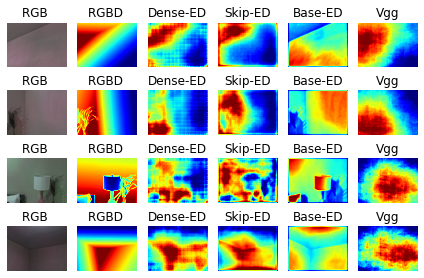

In [6]:
print_comparison(dict_model, train_loader, rows=4, offset=0, save_path='',name='')

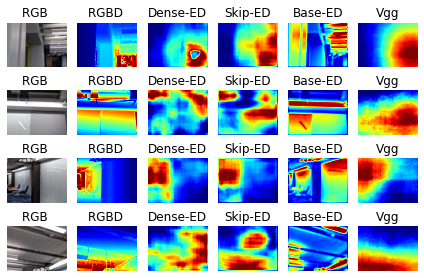

In [3]:
test_set = CustomDataset(csv_test_path, perc_dataset=1, transform=rgb_transformations_test(device), target_transform=depth_map_transformations_test(device))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=shuffle)

print_comparison(dict_model, val_loader, rows=4, offset=0, save_path='',name='')

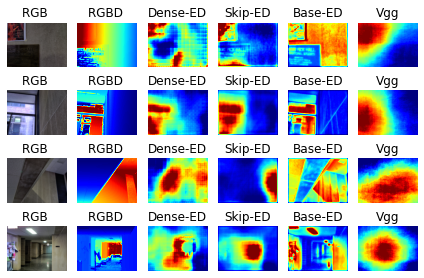

In [4]:
#val_set = CustomDataset(csv_val_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_no_clip(size,device))
test_set = CustomDataset(csv_test_path, perc_dataset=percentuale, transform=rgb_transformations_base(size,device), target_transform=depth_map_transformations_no_clip(size,device))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print_comparison(dict_model, test_loader, rows=4, offset=0, save_path='',name='')